In [1]:
import warnings
from loguru import logger

warnings.simplefilter(action='ignore', category=FutureWarning)

from edgedroid.models.timings import *
import edgedroid.data as default_data

logger.enable("edgedroid")

data = default_data.load_curve_fitting_data()
data

,participant,prev_ttf,exec_time,prev_duration,neuro,neuroticism
0,134146,0.0,3.029,"[-inf, 5.0)","[-inf, 0.5)",0.375
1,134146,0.0,4.004,"[-inf, 5.0)","[-inf, 0.5)",0.375
2,134146,0.0,2.625,"[-inf, 5.0)","[-inf, 0.5)",0.375
3,134146,0.0,4.680,"[-inf, 5.0)","[-inf, 0.5)",0.375
4,134146,0.0,5.197,"[-inf, 5.0)","[-inf, 0.5)",0.375
...,...,...,...,...,...,...
6755,137353,0.0,6.358,"[5.0, 9.0)","[0.5, inf)",0.625
6756,137353,0.0,3.840,"[5.0, 9.0)","[0.5, inf)",0.625
6757,137353,0.0,2.932,"[9.0, inf)","[0.5, inf)",0.625
6758,137353,0.0,1.874,"[9.0, inf)","[0.5, inf)",0.625


In [2]:
import numpy as np

data["outlier"] = False
for _, df in data.groupby(["prev_ttf", "prev_duration"]):
    outliers = ((df["exec_time"] > np.percentile(df["exec_time"], 95)) | (df["exec_time"] < np.percentile(df["exec_time"], 5)))
    outlier_idx = df.loc[outliers].index
    data.loc[outlier_idx, "outlier"] = True
data

,participant,prev_ttf,exec_time,prev_duration,neuro,neuroticism,outlier
0,134146,0.0,3.029,"[-inf, 5.0)","[-inf, 0.5)",0.375,False
1,134146,0.0,4.004,"[-inf, 5.0)","[-inf, 0.5)",0.375,False
2,134146,0.0,2.625,"[-inf, 5.0)","[-inf, 0.5)",0.375,False
3,134146,0.0,4.680,"[-inf, 5.0)","[-inf, 0.5)",0.375,False
4,134146,0.0,5.197,"[-inf, 5.0)","[-inf, 0.5)",0.375,False
...,...,...,...,...,...,...,...
6755,137353,0.0,6.358,"[5.0, 9.0)","[0.5, inf)",0.625,False
6756,137353,0.0,3.840,"[5.0, 9.0)","[0.5, inf)",0.625,False
6757,137353,0.0,2.932,"[9.0, inf)","[0.5, inf)",0.625,False
6758,137353,0.0,1.874,"[9.0, inf)","[0.5, inf)",0.625,False


In [3]:
from collections import deque
import pandas as pd
from typing import Tuple, Deque
from tqdm.notebook import tqdm

result_rows = deque()
fit_mse_rows = deque()
for participant in tqdm(data["participant"].unique(), desc="Run"):
    class MultiCurveFittingTestModel(MultiCurveFittingExecutionTimeModel):
        @staticmethod
        def get_data() -> pd.DataFrame:
            data = MultiCurveFittingExecutionTimeModel.get_data()
            return data[data["participant"] != participant].copy()
        
        def __init__(self, neuroticism: float):
            super().__init__(
                neuroticism=neuroticism,
            )
            
    class Legacy(LegacyModel):
        @staticmethod
        def get_data() -> pd.DataFrame:
            data = MultiCurveFittingExecutionTimeModel.get_data()
            return data[data["participant"] != participant].copy()
        
        
    class PowerFitTestModel(MultiCurveFittingTestModel):
        _fit_functions = (PowerFit,)
        
    class SquareFitTestModel(MultiCurveFittingTestModel):
        _fit_functions = (SquareFit,)
        
    class CubeFitTestModel(MultiCurveFittingTestModel):
        _fit_functions = (CubeFit,)
        
    class ExponentialFitTestModel(MultiCurveFittingTestModel):
        _fit_functions = (ExponentialFit,)
        
    def get_test_data(*args, **kwargs) -> (
        Tuple[
            pd.DataFrame,
            pd.arrays.IntervalArray,
            pd.arrays.IntervalArray,
            pd.arrays.IntervalArray,
        ]
    ):
        data, *rest = default_data.load_default_exec_time_data()
        return (data[data["run_id"] != participant].copy(), *rest)

    class NaiveTestModel(FirstOrderETM):
        get_data = get_test_data
        
    class NaiveAggTestModel(FirstOrderAggregateETM):
        get_data = get_test_data
            
    run_data = data[data["participant"] == participant].copy()

    neuroticism = run_data["neuroticism"].unique()[0]
    naive_model = NaiveTestModel()
    naive_mean_model = NaiveAggTestModel(np.mean)
    naive_median_model = NaiveAggTestModel(np.median)
    
    power_fit_model = PowerFitTestModel(neuroticism)
    square_fit_model = SquareFitTestModel(neuroticism)
    cube_fit_model = CubeFitTestModel(neuroticism)
    exponential_fit_model = ExponentialFitTestModel(neuroticism)
    multi_fit_model = MultiCurveFittingExecutionTimeModel(neuroticism)
    
    legacy_model = Legacy()
    
    # deque containing (model name, model object)
    models: Deque[Tuple[str, ExecutionTimeModel]] = deque()
    models.extend((
        # ("a * x^b + c", power_fit_model),
        # ("a * x^2 + b * x + c", square_fit_model),
        ("a * x^3 + b * x^2 + c * x + d", cube_fit_model),
        # ("a * e^x + b", exponential_fit_model),
        # ("multi curve", multi_fit_model),
    ))
    
    # get the fit mses
    for name, model in models:
        for duration, fn in model._exec_time_funcs.items():
            fit_mse_rows.append({"participant": participant, "model": name, "duration": duration, "fn": fn.name, "mse": fn.mse})
            
    models.extend((
        ("1st order", naive_model),
        ("1st order (median)", naive_median_model),
        ("1st order (mean)", naive_mean_model),
        ("legacy", legacy_model)
    ))
        
    for _ in range(1):
        for i, (prev_ttf, exec_time, neuro, prev_duration, outlier) in enumerate(run_data[["prev_ttf", "exec_time", "neuro", "prev_duration", "outlier"]].itertuples(index=False)):
            for model_name, model in models:
                if i == 0:
                    # reset the model between runs
                    model.reset()
                else:
                    # first row has no previous ttf
                    model.advance(prev_ttf)
                    
                prediction = model.get_execution_time()
                error = prediction - exec_time
                result_rows.append({
                    "step": i,
                    "real": exec_time,
                    "prediction": prediction,
                    "error": error,
                    "sqr_error": np.square(error),
                    "model": model_name,
                    "duration": prev_duration,
                    "neuro": neuro,
                    "outlier": outlier,
                })

results = pd.DataFrame(result_rows)
for col in ("model", ):  # "kernel"):
    results[col] = results[col].astype("category")

fit_mses: pd.DataFrame = pd.DataFrame(fit_mse_rows)

results.to_parquet("./full_validation_marked_outliers.parquet")
results


# remove outliers from curves
# include old edgedroid
# choose the best models and carry this forward - experimentation, evaluation
# constant ttfs
# some variations
# maybe qdisc
# autoregressive process on the delays

Run:   0%|          | 0/40 [00:00<?, ?it/s]

2024-08-11 23:36:45.391 | DEBUG    | edgedroid.models.timings.curve:__init__:121 - Curve fitting aggregation function: outliers_to_nan_then_mean
2024-08-11 23:36:45.432 | INFO     | edgedroid.models.timings.curve:__init__:146 - Fitting execution time functions to data...
2024-08-11 23:36:45.468 | INFO     | edgedroid.models.timings.curve:__init__:154 - New best fit function for duration [-inf, 5.0): a * x^b + c (MSE: 0.04, prev. MSE 0.04)
2024-08-11 23:36:45.496 | INFO     | edgedroid.models.timings.curve:__init__:154 - New best fit function for duration [5.0, 9.0): a * x^b + c (MSE: 0.09, prev. MSE 0.09)
2024-08-11 23:36:45.500 | INFO     | edgedroid.models.timings.curve:__init__:154 - New best fit function for duration [9.0, inf): a * x^b + c (MSE: 0.05, prev. MSE 0.05)
2024-08-11 23:36:45.501 | DEBUG    | edgedroid.models.timings.curve:__init__:121 - Curve fitting aggregation function: outliers_to_nan_then_mean
2024-08-11 23:36:45.537 | INFO     | edgedroid.models.timings.curve:__in

,step,real,prediction,error,sqr_error,model,duration,neuro,outlier
0,0,3.029,4.925693,1.896693,3.597444,a * x^3 + b * x^2 + c * x + d,"[-inf, 5.0)","[-inf, 0.5)",False
1,0,3.029,3.629361,0.600361,0.360433,1st order,"[-inf, 5.0)","[-inf, 0.5)",False
2,0,3.029,5.261648,2.232648,4.984719,1st order (median),"[-inf, 5.0)","[-inf, 0.5)",False
3,0,3.029,5.873496,2.844496,8.091159,1st order (mean),"[-inf, 5.0)","[-inf, 0.5)",False
4,0,3.029,6.882000,3.853000,14.845609,legacy,"[-inf, 5.0)","[-inf, 0.5)",False
...,...,...,...,...,...,...,...,...,...
33795,168,4.241,3.173563,-1.067437,1.139422,a * x^3 + b * x^2 + c * x + d,"[9.0, inf)","[0.5, inf)",False
33796,168,4.241,4.872019,0.631019,0.398185,1st order,"[9.0, inf)","[0.5, inf)",False
33797,168,4.241,5.211066,0.970066,0.941028,1st order (median),"[9.0, inf)","[0.5, inf)",False
33798,168,4.241,5.821658,1.580658,2.498480,1st order (mean),"[9.0, inf)","[0.5, inf)",False


In [4]:
model_fit_mses = fit_mses.groupby(["model"])["mse"].mean().sort_values()
model_fit_mses

model
a * x^3 + b * x^2 + c * x + d    0.053184
Name: mse, dtype: float64

In [5]:
print(model_fit_mses.to_latex(float_format="\\(%0.03f\\)", caption="Average fit MSEs for the realistic models"))

\begin{table}
\caption{Average fit MSEs for the realistic models}
\begin{tabular}{lr}
\toprule
 & mse \\
model &  \\
\midrule
a * x^3 + b * x^2 + c * x + d & \(0.053\) \\
\bottomrule
\end{tabular}
\end{table}



In [6]:
results.query("~outlier").groupby(["model", "neuro", "duration"], observed=True)["sqr_error"].mean().sort_values(ascending=True)

model                          neuro        duration   
a * x^3 + b * x^2 + c * x + d  [-inf, 0.5)  [9.0, inf)      2.828998
legacy                         [-inf, 0.5)  [9.0, inf)      3.272545
a * x^3 + b * x^2 + c * x + d  [-inf, 0.5)  [5.0, 9.0)      3.417326
                               [0.5, inf)   [5.0, 9.0)      3.505638
                                            [9.0, inf)      3.635725
1st order (median)             [-inf, 0.5)  [5.0, 9.0)      3.758241
a * x^3 + b * x^2 + c * x + d  [0.5, inf)   [-inf, 5.0)     3.759478
1st order (median)             [0.5, inf)   [5.0, 9.0)      3.785696
legacy                         [-inf, 0.5)  [5.0, 9.0)      3.846595
1st order (median)             [-inf, 0.5)  [9.0, inf)      3.910987
1st order (mean)               [0.5, inf)   [-inf, 5.0)     3.981399
1st order (median)             [0.5, inf)   [-inf, 5.0)     4.017745
                               [-inf, 0.5)  [-inf, 5.0)     4.057085
a * x^3 + b * x^2 + c * x + d  [-inf, 0.5)  [-i

In [7]:
mse_results = results.query("~outlier").groupby(["model"], observed=True)["sqr_error"].describe().sort_values(by="mean", ascending=True)
mse_results

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
a * x^3 + b * x^2 + c * x + d,6083.0,3.664289,5.590054,1.169998e-06,0.425354,1.809720,4.722671,76.188207
1st order (median),6083.0,3.969279,6.069358,6.192399e-08,0.456102,2.314209,4.775917,72.082642
1st order (mean),6083.0,4.489805,5.435193,1.201064e-07,0.809556,2.674773,6.238325,61.955413
legacy,6083.0,5.230826,9.249210,0.000000e+00,0.344569,1.718721,6.262506,93.934864
1st order,6083.0,14.516967,50.212278,4.609248e-08,0.879799,3.998559,12.664669,1133.027455


In [8]:
mse_results["mean"]

model
a * x^3 + b * x^2 + c * x + d     3.664289
1st order (median)                3.969279
1st order (mean)                  4.489805
legacy                            5.230826
1st order                        14.516967
Name: mean, dtype: float64

In [9]:
mse_results_with_outliers = results.groupby(["model"], observed=True)["sqr_error"].describe().sort_values(by="mean", ascending=True)
mse_results_with_outliers["mean"]

model
a * x^3 + b * x^2 + c * x + d     9.785567
1st order (median)               10.084425
1st order (mean)                 10.268799
legacy                           11.931643
1st order                        19.969935
Name: mean, dtype: float64

In [10]:
mse_models = pd.merge(mse_results[["mean"]], mse_results_with_outliers[["mean"]], how="inner", left_index=True, right_index=True, suffixes=("_no_outliers", "_with_outliers"))
mse_models

,mean_no_outliers,mean_with_outliers
model,,
a * x^3 + b * x^2 + c * x + d,3.664289,9.785567
1st order (median),3.969279,10.084425
1st order (mean),4.489805,10.268799
legacy,5.230826,11.931643
1st order,14.516967,19.969935


In [11]:
print(mse_models[["mean_with_outliers", "mean_no_outliers"]].to_latex(float_format="\\(%0.03f\\)", caption="MSE of the evaluated models"))

\begin{table}
\caption{MSE of the evaluated models}
\begin{tabular}{lrr}
\toprule
 & mean_with_outliers & mean_no_outliers \\
model &  &  \\
\midrule
a * x^3 + b * x^2 + c * x + d & \(9.786\) & \(3.664\) \\
1st order (median) & \(10.084\) & \(3.969\) \\
1st order (mean) & \(10.269\) & \(4.490\) \\
legacy & \(11.932\) & \(5.231\) \\
1st order & \(19.970\) & \(14.517\) \\
\bottomrule
\end{tabular}
\end{table}



In [12]:
mse_per_step = results[~results["outlier"]].groupby(["model", "step"])["sqr_error"].mean().reset_index()
mse_per_step["step"] += 1

mse_per_step["model"] = mse_per_step["model"].replace(
    {
        "1st order": "Ref. Stochastic",
        "1st order (mean)": "Ref. Average",
        "1st order (median)": "Ref. Median",
        "a * x^b + c": r"$ a * x^b + c $",
        "a * x^2 + b * x + c": "2nd order polynomial",
        "a * x^3 + b * x^2 + c * x + d": "3rd order polynomial",
        "a * e^x + b": "Exponential",
        "multi curve": "Multi-curve",
        "legacy": "Legacy EdgeDroid 1.0"
    }
)

mse_per_step

,model,step,sqr_error
0,Ref. Stochastic,1,11.255066
1,Ref. Stochastic,2,11.596374
2,Ref. Stochastic,3,15.587717
3,Ref. Stochastic,4,10.590703
4,Ref. Stochastic,5,9.636043
...,...,...,...
840,Legacy EdgeDroid 1.0,165,2.133981
841,Legacy EdgeDroid 1.0,166,3.019650
842,Legacy EdgeDroid 1.0,167,4.121817
843,Legacy EdgeDroid 1.0,168,2.242859


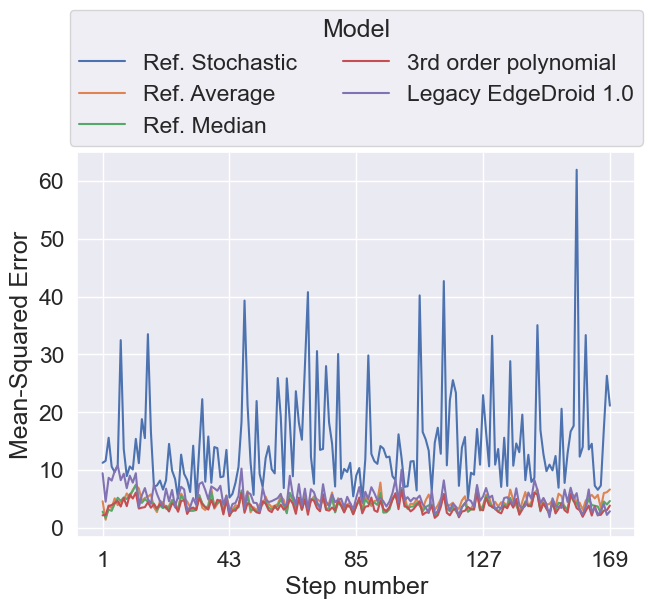

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("paper")
sns.set(font_scale=1.5)

fig, ax = plt.subplots()
ax = sns.lineplot(mse_per_step, x="step", hue="model", y="sqr_error", ax=ax)
ax.set_xlabel("Step number")
ax.set_ylabel("Mean-Squared Error")
ax.set_xticks(np.linspace(1, 169, 5, dtype=int))
# ax.set_yscale("log")
sns.move_legend(ax, "upper center", title="Model", bbox_to_anchor=(.5, 1.4), ncols=2)
fig.set_size_inches((2*3.6, 5))
# fig.tight_layout()
plt.show()